In [54]:
"""
01_clean_and_explore.ipynb

Purpose
-------
This notebook performs preprocessing and exploratory inspection of the SECOM
semiconductor manufacturing dataset. The goal is to produce clean, frozen
train/validation/test datasets that can be used downstream for modeling and
association analysis without further modification.

Inputs
------
- secom.data
- secom_labels.data

Outputs
-------
- X_train.csv, y_train.csv
- X_val.csv, y_val.csv
- X_test.csv, y_test.csv

(All outputs are written to ../data/cleaned and are consumed directly by
downstream notebooks.)

Overview of Processing Steps
----------------------------
1. Load raw feature and label files and verify alignment.
2. Remove duplicate variables to eliminate redundant measurements.
3. Inspect missingness patterns to understand data sparsity.
4. Split data into training (60%), validation (20%), and test (20%) sets using
   stratification to preserve the failure/pass class distribution.
5. Remove non-informative variables, including:
   - Constant or near-constant features
   - Variables measured exclusively or almost exclusively in one outcome class
   - Attributes missing in ≥ 60% of observations
   (All feature-filtering criteria are determined on the training set and
   applied consistently to validation and test sets.)
6. Perform mean imputation using statistics computed from the training set only,
   then apply these values to all splits to avoid leakage.
7. Standardize all attributes to comparable scales.
8. Conduct exploratory principal component analysis (PCA) to assess structure
   and variance in the cleaned feature space prior to modeling.

Scope Notes
-----------
This notebook is intentionally limited to data cleaning, splitting, and
exploratory analysis. No models are trained and no features are selected here.
All downstream analyses assume the outputs of this notebook are fixed.
"""

'\n01_clean_and_explore.ipynb\n\nPurpose\n-------\nThis notebook performs preprocessing and exploratory inspection of the SECOM\nsemiconductor manufacturing dataset. The goal is to produce clean, frozen\ntrain/validation/test datasets that can be used downstream for modeling and\nassociation analysis without further modification.\n\nInputs\n------\n- secom.data\n- secom_labels.data\n\nOutputs\n-------\n- X_train.csv, y_train.csv\n- X_val.csv, y_val.csv\n- X_test.csv, y_test.csv\n\n(All outputs are written to ../data/cleaned and are consumed directly by\ndownstream notebooks.)\n\nOverview of Processing Steps\n----------------------------\n1. Load raw feature and label files and verify alignment.\n2. Remove duplicate variables to eliminate redundant measurements.\n3. Inspect missingness patterns to understand data sparsity.\n4. Split data into training (60%), validation (20%), and test (20%) sets using\n   stratification to preserve the failure/pass class distribution.\n5. Remove non-inf

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Inspecting and Cleaning Data

### Loading data into dataframes and verify loaded correctly
In this step, raw SECOM process measurements and outcome labels are loaded,
parsed into structured dataframes, and basic checks to ensure
that the data were loaded and aligned correctly are performed.

In [56]:
rows = []
with open("../data/raw/secom_labels.data", "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        # split into 2 parts: outcome, and the rest of the line
        out_str, ts_str = line.split(None, 1)   # maxsplit=1 behavior
        rows.append((int(out_str), ts_str.strip().strip('"')))

raw_secom_labels_df = pd.DataFrame(rows, columns=["outcome", "timestamp"])

raw_secom_df = pd.read_csv(
    "../data/raw/secom.data",
    sep=r"\s+",
    engine="python",
    header=None,
)

raw_secom_df.columns = [f"attribute_{i}" for i in range(1, raw_secom_df.shape[1] + 1)]

print("\n==== Verify Data Loaded correctly to Dataframes ====")
print("Raw SECOM Labels DataFrame shape:", raw_secom_labels_df.shape)
print("Raw SECOM Data DataFrame shape:", raw_secom_df.shape)
print("Outcome distribution:")
print(raw_secom_labels_df["outcome"].value_counts())


==== Verify Data Loaded correctly to Dataframes ====
Raw SECOM Labels DataFrame shape: (1567, 2)
Raw SECOM Data DataFrame shape: (1567, 590)
Outcome distribution:
outcome
-1    1463
 1     104
Name: count, dtype: int64


### Note on Dataset Columns

Although the dataset documentation references 591 process variables, the released secom.data file contains 590 numeric columns per observation. All analyses are performed on the observed columns.

### Remove duplicate variables
In this step, the 2 dataframes are joined together first to obtain one complete dataframe. Duplicate columns are then dropped as duplicates can mess with our later analysis and dropping duplicate attributes not make us lose any information. 

In [57]:
# concat raw_secom_df with raw_secom_labels_df on axis=1
raw_secom_full_df = pd.concat([raw_secom_df, raw_secom_labels_df], axis=1)
print("\n==== Verify DataFrames Concatenated Correctly ====")
print("Raw SECOM Full DataFrame shape:", raw_secom_full_df.shape)
print("Outcome distribution:")
print(raw_secom_full_df["outcome"].value_counts())

# drop duplicates columns if any from raw_secom_full_df
dup_cols = raw_secom_full_df.T.duplicated()
df_no_dup_cols = raw_secom_full_df.loc[:, ~dup_cols]

print(f"Dropped {dup_cols.sum()} duplicate columns.")

print("\n==== DataFrame Shape After Dropping Duplicate Columns ====")
print(df_no_dup_cols.shape)



==== Verify DataFrames Concatenated Correctly ====
Raw SECOM Full DataFrame shape: (1567, 592)
Outcome distribution:
outcome
-1    1463
 1     104
Name: count, dtype: int64
Dropped 104 duplicate columns.

==== DataFrame Shape After Dropping Duplicate Columns ====
(1567, 488)


### Inspect the missingness of the data 
In this step, the NaN values in the dataset are inspected. 


==== Summary of Missing Values in SECOM Data ====


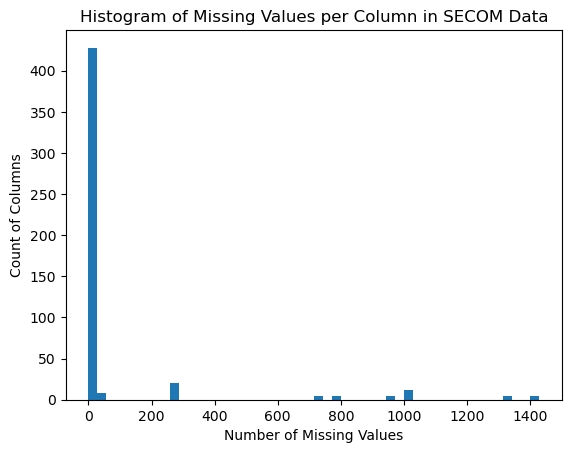

In [58]:
print("\n==== Summary of Missing Values in SECOM Data ====")
missing = df_no_dup_cols.isnull().sum()
missing.describe()

# print a histogram of the count of missing values per column for df_no_dup_cols
plt.hist(missing, bins=50)
plt.xlabel("Number of Missing Values")
plt.ylabel("Count of Columns")
plt.title("Histogram of Missing Values per Column in SECOM Data")
plt.show()

### Separate Data into training, validation and testing
In this step, before further cleaning, the data will be separated randomly into a train group 60%, validation group 20% and test group 20%. This is performed now to prevent any data leakage - we dont want to overfit to the test data, we want that to be isolated to get the best picture of how the model will generalize to data it hasnt seen. Because of the low proportion of fails in the data, we need to ensure that the sets each have a reasonable number of fail cases. To ensure this, we will randomly assign 20% of the fails to the test data, 20% to the validation data, and 60% to the train data.

In [59]:
# create a test_df, train_df and val_df

# -----------------------------
# Separate by class
# -----------------------------
df_fail = df_no_dup_cols[df_no_dup_cols["outcome"] == 1]    # fail
df_pass = df_no_dup_cols[df_no_dup_cols["outcome"] == -1]  # pass

# -----------------------------
# Sample test set (20% each class)
# -----------------------------
test_fail = df_fail.sample(frac=0.2, random_state=42)
test_pass = df_pass.sample(frac=0.2, random_state=42)

test_df = pd.concat([test_fail, test_pass])

# -----------------------------
# Remaining data after test split
# -----------------------------
remaining_df = df_no_dup_cols.drop(test_df.index)

remaining_fail = remaining_df[remaining_df["outcome"] == 1]
remaining_pass = remaining_df[remaining_df["outcome"] == -1]

# -----------------------------
# Sample validation set (20% of original → 25% of remaining)
# -----------------------------
# Since 80% remains after test split, 20% / 80% = 0.25
val_fail = remaining_fail.sample(frac=0.25, random_state=42)
val_pass = remaining_pass.sample(frac=0.25, random_state=42)

val_df = pd.concat([val_fail, val_pass])

# -----------------------------
# Remaining data is training set (60%)
# -----------------------------
train_df = remaining_df.drop(val_df.index)

# -----------------------------
# Shuffle each split
# -----------------------------
train_df = train_df.sample(frac=1, random_state=42)
val_df   = val_df.sample(frac=1, random_state=42)
test_df  = test_df.sample(frac=1, random_state=42)

# -----------------------------
# Verification
# -----------------------------
print("\n==== Verify Train / Validation / Test Split ====")

print("\nOriginal:")
print(df_no_dup_cols["outcome"].value_counts(normalize=True))

print("\nTrain:")
print(train_df["outcome"].value_counts(normalize=True))

print("\nValidation:")
print(val_df["outcome"].value_counts(normalize=True))

print("\nTest:")
print(test_df["outcome"].value_counts(normalize=True))

print("\nShapes:")
print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)



==== Verify Train / Validation / Test Split ====

Original:
outcome
-1    0.933631
 1    0.066369
Name: proportion, dtype: float64

Train:
outcome
-1    0.934043
 1    0.065957
Name: proportion, dtype: float64

Validation:
outcome
-1    0.932907
 1    0.067093
Name: proportion, dtype: float64

Test:
outcome
-1    0.933121
 1    0.066879
Name: proportion, dtype: float64

Shapes:
Train: (940, 488)
Validation: (313, 488)
Test: (314, 488)


### Remove variables with constant values or very low variance using the training data
In this step, variables that have constant values are removed from the data because they provide no information. These variables will identified using the training data only, and the variables will then be dropped from the traning, validation, and test sets. 

In [60]:
# identify names of constant columns in train_df
constant_cols = train_df.columns[train_df.nunique() == 1]
print(f"\nIdentified {len(constant_cols)} constant columns to drop.")

# Drop them from both train and test
train_df = train_df.drop(columns=constant_cols)
test_df = test_df.drop(columns=constant_cols)
val_df = val_df.drop(columns=constant_cols)

print("\n==== DataFrame Shapes After Dropping Constant Columns ====")
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Validation DataFrame shape:", val_df.shape)


Identified 12 constant columns to drop.

==== DataFrame Shapes After Dropping Constant Columns ====
Train DataFrame shape: (940, 476)
Test DataFrame shape: (314, 476)
Validation DataFrame shape: (313, 476)


### Remove variables measured within exclusively one class or almost exclusively one class
In this step, attributes that are recorded almost exclusively for only one class are not useful for our analysis and are dropped. We are interested in which attributes are most predictive of pass or fail with the goal of identifying where in the process improvements can be made. If an attribute is only measured for one outcome class, then its apparent predictive value reflects measurement availability rather than process behavior, and it does not help us determine whether it is a useful attribute to monitor when trying to improve the process. To do this, we will drop features that are measured in ≥95% of fails and ≤5% of passes or measured in ≥95% of passes and ≤5% of fails.

In [61]:
y = train_df["outcome"]
X = train_df.drop(columns=["outcome"])

fail_mask = y == 1
pass_mask = y == -1

drop_cols = []

for col in X.columns:
    p_fail = X.loc[fail_mask, col].notna().mean()
    p_pass = X.loc[pass_mask, col].notna().mean()

    if (p_fail >= 0.95 and p_pass <= 0.05) or (p_pass >= 0.95 and p_fail <= 0.05):
        drop_cols.append(col)

print(f"Dropping {len(drop_cols)} class-conditional measurement columns.")

train_df = train_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)
val_df   = val_df.drop(columns=drop_cols)

print("\n==== DataFrame Shapes After Dropping Class-Conditional Measurement Columns ====")
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Validation DataFrame shape:", val_df.shape)

Dropping 0 class-conditional measurement columns.

==== DataFrame Shapes After Dropping Class-Conditional Measurement Columns ====
Train DataFrame shape: (940, 476)
Test DataFrame shape: (314, 476)
Validation DataFrame shape: (313, 476)


### Inspect missingness of data in our training data
In this step, a histogram of the number of missing values per attribute is made to get a sense of the data after the above cleaning steps


==== Summary of Missing Values in SECOM Data ====


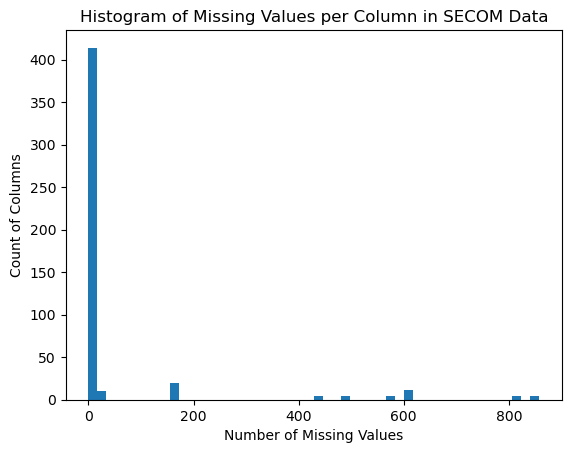

Number of attributes missing more than 60% of their values in train_df: 24


In [62]:
print("\n==== Summary of Missing Values in SECOM Data ====")
missing = train_df.isnull().sum()
missing.describe()

# print a histogram of the count of missing values per column for train_df
plt.hist(missing, bins=50)
plt.xlabel("Number of Missing Values")
plt.ylabel("Count of Columns")
plt.title("Histogram of Missing Values per Column in SECOM Data")
plt.show()

# print the number of attributes missing more than 60% of their values in train_df
num_missing_over_60pct = (missing > 0.6 * train_df.shape[0]).sum()
print(f"Number of attributes missing more than 60% of their values in train_df: {num_missing_over_60pct}")

### Drop attributes that have >= 60% of their data missing in the train_df
In this step, attributes that have more than 60% missing data will be dropped. Mean imputation will be used in a later step, and this relies on not too many missing values to be present. Theerefore, this threshold is chosen and attributes will be dropped from the training, validation, and test sets.

In [63]:
# find variables with >= 60% missingness in train_df
high_missing_cols = missing[missing >= 0.6 * train_df.shape[0]].index
print(f"Dropping {len(high_missing_cols)} columns with >= 60% missingness.")
train_df = train_df.drop(columns=high_missing_cols)
test_df  = test_df.drop(columns=high_missing_cols)
val_df   = val_df.drop(columns=high_missing_cols)
print("\n==== DataFrame Shapes After Dropping High Missingness Columns ====")
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Validation DataFrame shape:", val_df.shape)

Dropping 24 columns with >= 60% missingness.

==== DataFrame Shapes After Dropping High Missingness Columns ====
Train DataFrame shape: (940, 452)
Test DataFrame shape: (314, 452)
Validation DataFrame shape: (313, 452)


### Do mean imputation to fill in NaN's
In this step, the mean of each variable in the training set is computed. All NaN values in the training, validation, and test sets are replaced with these means. Mean imputation was chosen as a simple, assumption-light baseline that preserves the original feature space and supports interpretability in linear models. More complex imputation methods were avoided at this stage to prevent introducing unverified structure, distributional assumptions, or correlations that may reflect modeling artifacts rather than true process behavior. Given the exploratory goal of identifying attributes associated with pass/fail outcomes—rather than optimizing predictive performance—this approach provides a transparent reference point against which more sophisticated methods could later be compared.

In [64]:
# Drop timestamp from both train and test p- we wont need this
train_df = train_df.drop(columns=["timestamp"])
test_df  = test_df.drop(columns=["timestamp"])
val_df   = val_df.drop(columns=["timestamp"])


# find the mean of each attribute in the test_df and replace all missing values with the mean of that attribute
impute_values = train_df.mean()
train_df = train_df.fillna(impute_values)
test_df  = test_df.fillna(impute_values)
val_df   = val_df.fillna(impute_values)
print("\n==== DataFrames After Mean Imputation ====")
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print(train_df.isnull().sum(), "missing values remain in train_df after imputation.")
print(test_df.isnull().sum(), "missing values remain in test_df after imputation.")
print(val_df.isnull().sum(), "missing values remain in val_df after imputation.")


==== DataFrames After Mean Imputation ====
Train DataFrame shape: (940, 451)
Test DataFrame shape: (314, 451)
Validation DataFrame shape: (313, 451)
attribute_1      0
attribute_2      0
attribute_3      0
attribute_4      0
attribute_5      0
                ..
attribute_587    0
attribute_588    0
attribute_589    0
attribute_590    0
outcome          0
Length: 451, dtype: int64 missing values remain in train_df after imputation.
attribute_1      0
attribute_2      0
attribute_3      0
attribute_4      0
attribute_5      0
                ..
attribute_587    0
attribute_588    0
attribute_589    0
attribute_590    0
outcome          0
Length: 451, dtype: int64 missing values remain in test_df after imputation.
attribute_1      0
attribute_2      0
attribute_3      0
attribute_4      0
attribute_5      0
                ..
attribute_587    0
attribute_588    0
attribute_589    0
attribute_590    0
outcome          0
Length: 451, dtype: int64 missing values remain in val_df after impu

### export cleaned data files

In [65]:
import os

# ----------------------------
# Configuration
# ----------------------------
OUTCOME_COL = "outcome"
OUTPUT_DIR = "../data/cleaned"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------------
# Split X and y
# ----------------------------
X_train = train_df.drop(columns=[OUTCOME_COL])
y_train = train_df[[OUTCOME_COL]]

X_val = val_df.drop(columns=[OUTCOME_COL])
y_val = val_df[[OUTCOME_COL]]

X_test = test_df.drop(columns=[OUTCOME_COL])
y_test = test_df[[OUTCOME_COL]]

# ----------------------------
# Sanity checks
# ----------------------------
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]
assert X_test.shape[0] == y_test.shape[0]

assert list(X_train.columns) == list(X_val.columns) == list(X_test.columns)

# ----------------------------
# Save to CSV
# ----------------------------
X_train.to_csv(f"{OUTPUT_DIR}/X_train.csv", index=False)
y_train.to_csv(f"{OUTPUT_DIR}/y_train.csv", index=False)

X_val.to_csv(f"{OUTPUT_DIR}/X_val.csv", index=False)
y_val.to_csv(f"{OUTPUT_DIR}/y_val.csv", index=False)

X_test.to_csv(f"{OUTPUT_DIR}/X_test.csv", index=False)
y_test.to_csv(f"{OUTPUT_DIR}/y_test.csv", index=False)

print("✔ Cleaned datasets saved to:", OUTPUT_DIR)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

✔ Cleaned datasets saved to: ../data/cleaned
X_train shape: (940, 450)
X_val shape: (313, 450)
X_test shape: (314, 450)
